In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from skimage import io
from monolayer_tracking.segmented_comprehension import HeightMap, Image
from scipy import ndimage
import cellpose.utils as cp_utils
from pathlib import Path

from natsort import natsorted
from glob import glob

## CellPose GUI seg.npy to my format

In [3]:
# resume
seg_dir=Path(r'Y:\Segmentation\20240712 FUCCI halo ME adhered_suspended\segmented\adhered')
for n in tqdm(range(1,6)):
    file_path=Path(seg_dir/r'tile{}_seg.npy'.format(n))
    seg=np.load(file_path, allow_pickle=True).item()
    img_path=str(file_path.parents[0]).replace('Segmentation','Data').replace('segmented','')+'/'+file_path.name.replace('seg.npy', 'RGB.tif')
    img=io.imread(img_path)
    
    masks=remove_edge_masks(img[..., 2], seg['masks'], radius=2)
    outlines_list=cp_utils.outlines_list_multi(masks) # multiprocessing version of outlines_list
    outlines=cp_utils.masks_to_outlines(masks)

    export={'img':img, 'masks':masks, 'outlines':outlines, 'outlines_list':outlines_list}
    np.save(file_path, export)

  0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
for file_path in tqdm(file_paths):
    frame=Image(file_path, load_img=True)
    frame.img=frame.img[..., [1,0,2]] # flip G and R
    frame.to_seg_npy(file_path, overwrite_img=True)

  0%|          | 0/5 [00:00<?, ?it/s]

# Read heights out of MGX

In [48]:
seg_dir=Path(r'Y:\my_data\W1\20240715 FUCCI halo ME 6days adhered_suspended\segmented\adhered')
file_paths=natsorted(glob(str(seg_dir/'*.npy')))

tiles=[HeightMap(seg_path, scale=0.1625, z_scale=1, load_img=True) for seg_path in tqdm(file_paths)]

  0%|          | 0/12 [00:00<?, ?it/s]

In [85]:
root_dir=Path(r'Y:\raw_data\W1\20240710 FUCCI halo comparison\fine_zstack_mgx')
mesh_paths=natsorted(glob(str(root_dir/'binarized*.tif')))
scale=0.16
z_scales=np.array([float(mesh_path.split('_')[-1].replace('.tif','')) for mesh_path in mesh_paths])*scale
seg_path=r"Y:\raw_data\W1\20240710 FUCCI halo comparison\fine_zstack_mgx\fine_zstack_seg.npy"

tiles=[HeightMap(seg_path, mesh_path=mesh_path, scale=scale, z_scale=z_scale) for mesh_path, z_scale in zip(tqdm(mesh_paths, z_scales))]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Andy\AppData\Local\Temp\ipykernel_18152\394589008.py:8: RuntimeWarning: Mean of empty slice
  binned_volume_data[i]=np.nanmean(volume_data[(volume>bins[i]) & (volume<bins[i+1])])
c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'z step size vs. volume measurement error (compared to 0.08um spacing)')

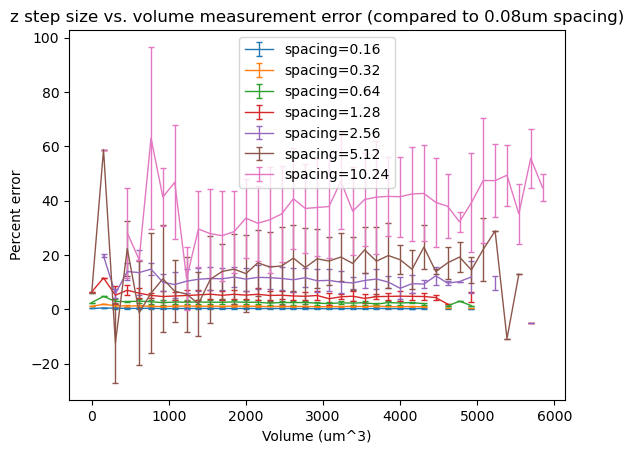

In [98]:
for volume, z_scale in zip(volumes[1:], z_scales[1:]):
    volume_data=(volume-volumes[0])*100/volumes[0]
    # bin and average volume_data
    bins=np.linspace(0, 6000, 40)
    binned_volume_data=np.zeros(len(bins)-1)
    binned_volume_std=np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        binned_volume_data[i]=np.nanmean(volume_data[(volume>bins[i]) & (volume<bins[i+1])])
        binned_volume_std[i]=np.nanstd(volume_data[(volume>bins[i]) & (volume<bins[i+1])])

    plt.errorbar(bins[:-1], binned_volume_data, yerr=binned_volume_std, linewidth=1, capsize=2, label=f'spacing={z_scale:.2f}')
    #plt.scatter(volume, volume_data, label=f'spacing={z_scale:.2f}', s=1)

plt.ylabel('Percent error')
plt.xlabel('Volume (um^3)')
plt.legend()

plt.title('z step size vs. volume measurement error (compared to 0.08um spacing)')

In [10]:
root_dir=r'Y:\Segmentation\20240622 FUCCI halo'
ME_0622_files=[f'ME/segmented/tile{n}_seg.npy' for n in range(1,10)]

ME_0622=[HeightMap(f'{root_dir}/{file}', scale=0.16125, load_img=True) for file in tqdm(ME_0622_files)]

for data in tqdm(ME_0622):
    data.get_volumes()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [21]:
root_dir=r'Y:\Segmentation\20240704 FUCCI halo 2days oil'
ME_files=[f'ME/segmented/tile{n}_seg.npy' for n in range(1,6)]
ME_replenished_files=[f'ME replenished/segmented/tile{n}_seg.npy' for n in range(1,7)]

ME=[HeightMap(f'{root_dir}/{file}', scale=0.16125, load_img=True) for file in tqdm(ME_files)]
ME_replenished=[HeightMap(f'{root_dir}/{file}', scale=0.16125, load_img=True) for file in tqdm(ME_replenished_files)]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
root_dir=r'Y:\Segmentation\20240705 FUCCI halo 3days water'
ME_files=[f'ME replenish/segmented/tile{n}_seg.npy' for n in range(1,9)]

ME_0705=[HeightMap(f'{root_dir}/{file}', scale=0.16125, load_img=True) for file in tqdm(ME_files)]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
for data in tqdm(ME_0705+ME_0622):
    data.get_volumes()

  0%|          | 0/8 [00:00<?, ?it/s]

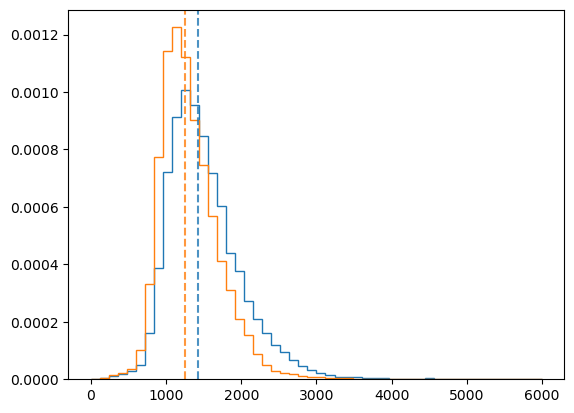

In [11]:
ME_0705_volumes=np.concatenate([data.volumes for data in ME_0705])
ME_0622_volumes=np.concatenate([data.volumes for data in ME_0622])

plt.hist(ME_0705_volumes, range=(0,6000), bins=50, histtype='step', density=True)
plt.hist(ME_0622_volumes, range=(0,6000), bins=50, histtype='step', density=True)
plt.axvline(np.nanmedian(ME_0705_volumes), color='C0', label='ME 0622', linestyle='--', alpha=0.8)
plt.axvline(np.nanmedian(ME_0622_volumes), color='C1', label='ME 0622', linestyle='--', alpha=0.8)

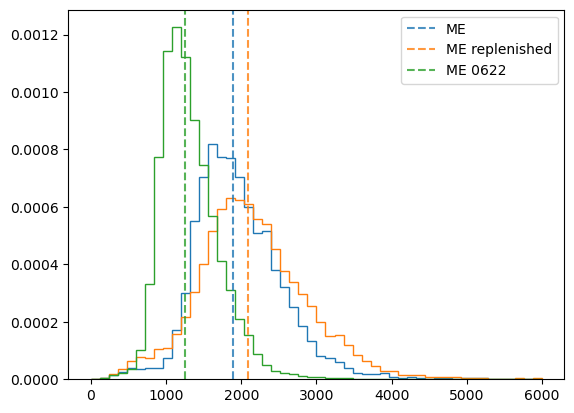

In [31]:
ME_volumes=np.concatenate([data.volumes for data in ME])
ME_replenished_volumes=np.concatenate([data.volumes for data in ME_replenished])
ME_0622_volumes=np.concatenate([data.volumes for data in ME_0622])

plt.hist(ME_volumes, range=(0,6000), bins=50, histtype='step', density=True)
plt.hist(ME_replenished_volumes, range=(0,6000), bins=50, histtype='step', density=True)
plt.hist(ME_0622_volumes, range=(0,6000), bins=50, histtype='step', density=True)

#print(np.median(volumes), np.median(SC_volumes))
plt.axvline(np.nanmedian(ME_volumes), color='C0', label='ME', linestyle='--', alpha=0.8)
plt.axvline(np.nanmedian(ME_replenished_volumes), color='C1', label='ME replenished', linestyle='--', alpha=0.8)
plt.axvline(np.nanmedian(ME_0622_volumes), color='C2', label='ME 0622', linestyle='--', alpha=0.8)

plt.legend()

In [122]:
tif_tile=HeightMap(r'Y:\Segmentation\20240520 FUCCI halo ME 40x\tile1\tile1_seg.npy', scale=0.16125, load_img=True)
tif_tile.get_volumes()

array([1684.1391167 , 1954.03067676, 1414.86745342, ..., 1109.8390689 ,
        735.77708544,           nan])

In [ ]:
root_dir='Z:/Andy/segmentation/20240520 FUCCI halo ME 40x/'
files=['tile1','tile2']

dataset=[HeightMap(f'{root_dir}{file}/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

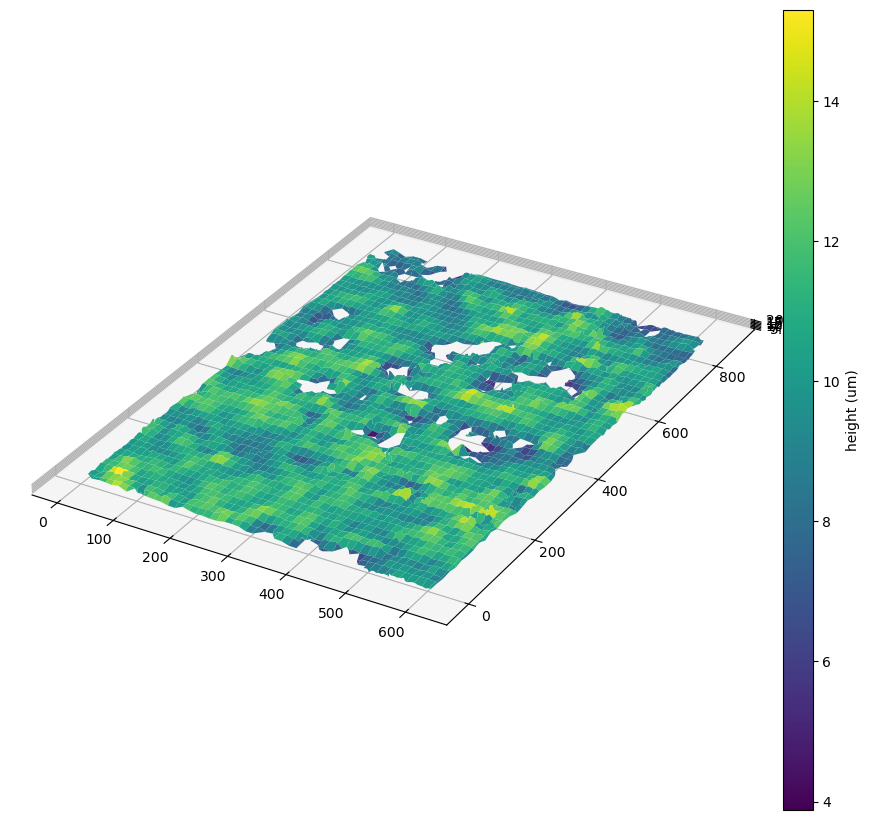

In [123]:
fig, ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': '3d'})
z=tif_tile.z
#z[np.isnan(z)]=0
cb=ax.plot_surface(tif_tile.x, tif_tile.y, tif_tile.z, cmap='viridis')

cax=fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(cb, cax=cax, label='height (um)')

ax.set_aspect('equal')
#ax.axis('off')
#plt.savefig('plots/adhered_volumes/20240520_tile1_height_map.jpg', dpi=300, bbox_inches='tight')

In [413]:
root_dir='Z:/Andy/segmentation/20240520 FUCCI halo ME 40x/'
files=['tile1','tile2']

dataset=[HeightMap(f'{root_dir}{file}/{file}_seg.npy', scale=0.16125, load_img=True) for file in tqdm(files)]

  0%|          | 0/2 [00:00<?, ?it/s]

In [370]:
#tile1=HeightMap(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile1\tile1_seg.npy')
tile2=HeightMap(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile2\tile2_seg.npy')

# measure volumes

In [49]:
[tile.get_volumes() for tile in tqdm(tiles)]
pass

  0%|          | 0/12 [00:00<?, ?it/s]

In [372]:
import pandas as pd
vol_0407_SC=pd.read_pickle(r'F:\my_data\Segmentation\20240407 FUCCI suspension\volumes\SC.pkl')
vol_0412_ME=pd.read_pickle(r'F:\my_data\Segmentation\20240412 FUCCI_halo_40x suspension ME\volumes\ME.pkl')

Text(0.5, 0, 'volume (um)')

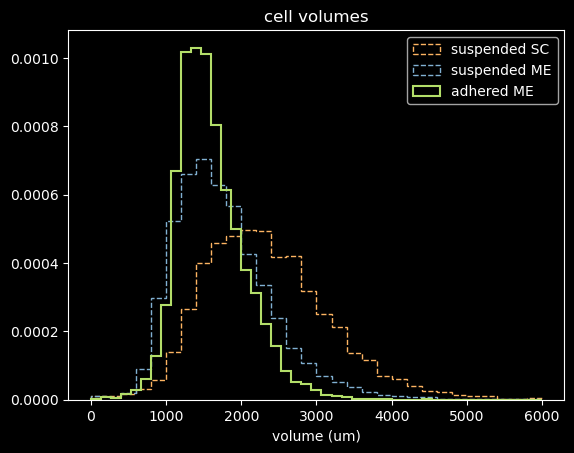

In [416]:
volumes=np.concatenate([tile.volumes for tile in dataset])

plt.hist(np.concatenate(vol_0407_SC[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='suspended SC', color='C5')
plt.hist(np.concatenate(vol_0412_ME[1:]), bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', label='suspended ME', color='C4')
plt.hist(volumes, bins=45, range=(0,6000), histtype='step', label='adhered ME', density=True, linewidth=1.5, color='C6')

plt.title('cell volumes')

plt.legend()
plt.xlabel('volume (um)')
#plt.savefig('plots/adhered_volumes/20240520_ME_hist.jpg', dpi=300, bbox_inches='tight')

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase

  0%|          | 0/4 [00:00<?, ?it/s]

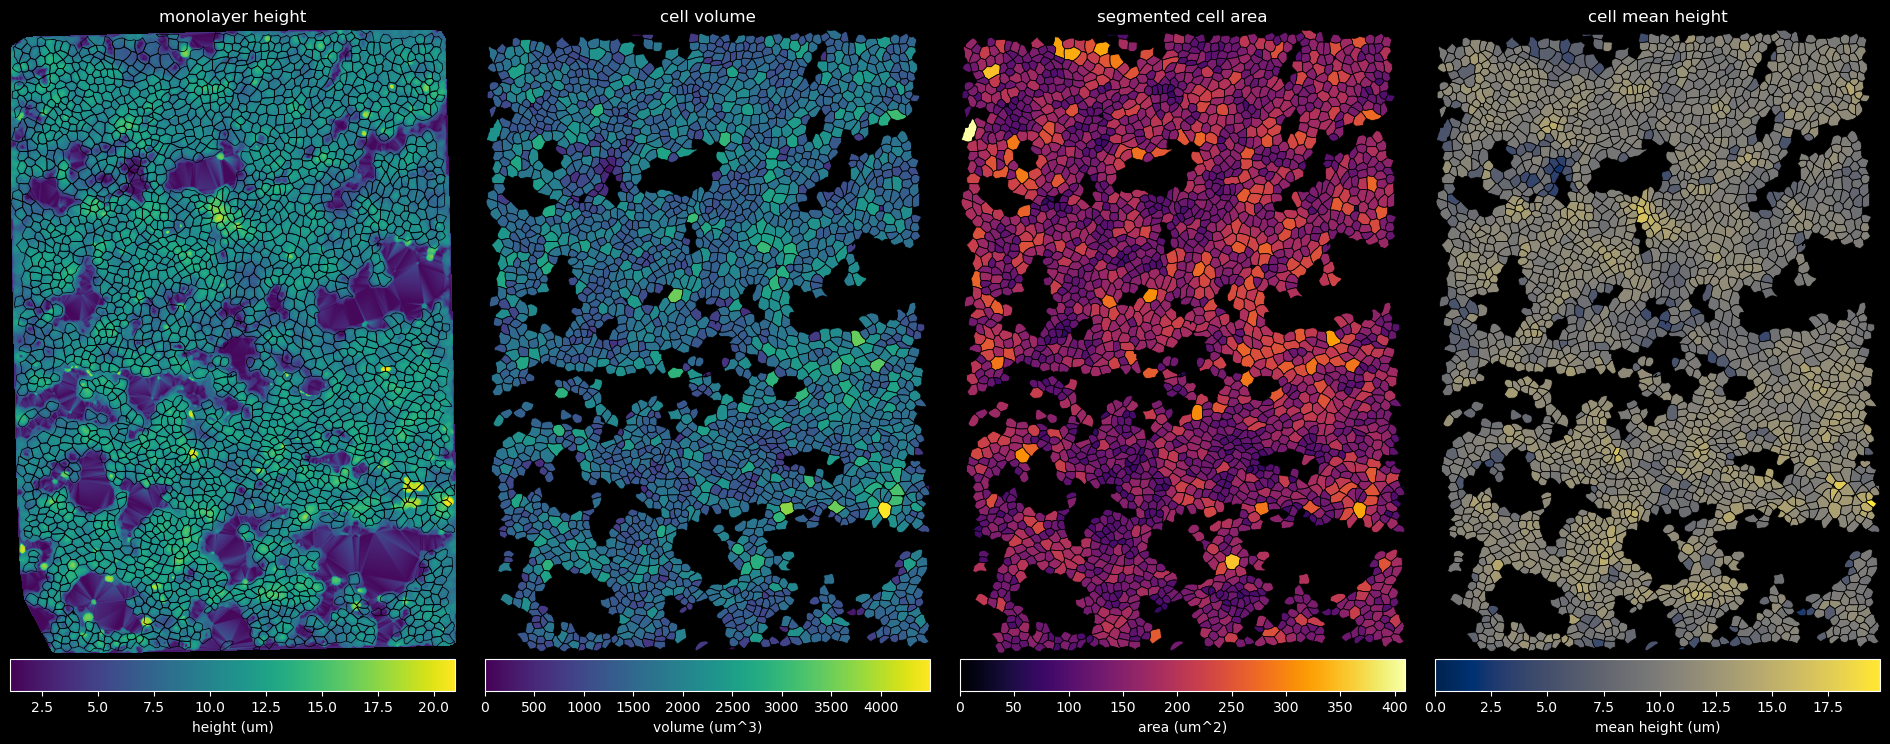

In [374]:
# volume measurement demo
# TODO: use patchcollections
frame=dataset[0]

plt.style.use('dark_background')
figsize=5

fig, (heightAx, volAx, areaAx, meanHeightAx)=plt.subplots(1,4, figsize=(3.8*figsize,figsize*np.divide(*frame.masks.shape)), sharex=True, sharey=True)


pbar=tqdm(total=4)
#---------heights---------
heightMap=heightAx.imshow(z, cmap='viridis')
for cell in frame.cells:
    heightAx.plot(cell.outline[:,0], cell.outline[:,1], c='k', linewidth=0.5)
pbar.update(1)

#---------volumes---------
#volAx.imshow(np.ones_like(frame.masks)*np.nan)
for cell in frame.cells:
    volAx.fill(*cell.outline.T, color=plt.cm.viridis(cell.volume/np.nanmax(frame.volumes)), edgecolor='k', linewidth=0.5)

volMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=np.nanmax(frame.volumes)), cmap='viridis')
volMap.set_array([])
pbar.update(1)

#---------areas---------
areas=frame.cell_areas(scaled=True)
for cell, area in zip(frame.cells, areas):
    areaAx.fill(*cell.outline.T, color=plt.cm.inferno(area/areas.max()), edgecolor='k', linewidth=0.5)
areaMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=areas.max()), cmap='inferno')
areaMap.set_array([])
pbar.update(1)

#---------cell heights---------
for cell in frame.cells:
    meanHeightAx.fill(*cell.outline.T, color=plt.cm.cividis(cell.height/np.nanmax(frame.mean_heights)), edgecolor='k', linewidth=0.5)
meanHeightMap=cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=np.nanmax(frame.mean_heights)), cmap='cividis')
meanHeightMap.set_array([])
pbar.update(1)

# remove axes
for ax in (heightAx, areaAx, meanHeightAx, volAx):
    ax.axis('off')
    ax.set_aspect('equal')
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)

heightAx.set_title('monolayer height')
areaAx.set_title('segmented cell area')
meanHeightAx.set_title('cell mean height')
volAx.set_title('cell volume')

def subplot_colorbar(ax, mappable, label=None, cmap='viridis', location='right', pad=0.05):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider=make_axes_locatable(ax)
    size=f'{100*pad}%'
    if location=='right' or location=='left':
        orientation='vertical'
    elif location=='top' or location=='bottom':
        orientation='horizontal'
    else:
        raise ValueError('location must be right, left, top, or bottom')
    
    cax=divider.append_axes(location, size=size, pad=pad)
    cbar=fig.colorbar(mappable, cax=cax, orientation=orientation, cmap=cmap, label=label)
    return cbar

# colorbars
subplot_colorbar(heightAx, heightMap, cmap='viridis', label='height (um)', location='bottom')
subplot_colorbar(areaAx, areaMap, cmap='inferno', label='area (um^2)', location='bottom')
subplot_colorbar(meanHeightAx, meanHeightMap, cmap='cividis', label='mean height (um)', location='bottom')
subplot_colorbar(volAx, volMap, cmap='viridis', label='volume (um^3)', location='bottom')

fig.tight_layout()
#plt.savefig('plots/adhered_volumes/20240520_tile1.jpg', dpi=300, bbox_inches='tight')

pbar.close()

In [434]:
volumes=np.concatenate([tile.volumes for tile in dataset])
areas=np.concatenate([tile.cell_areas(scaled=True) for tile in dataset])
heights=np.concatenate([tile.mean_heights for tile in dataset])

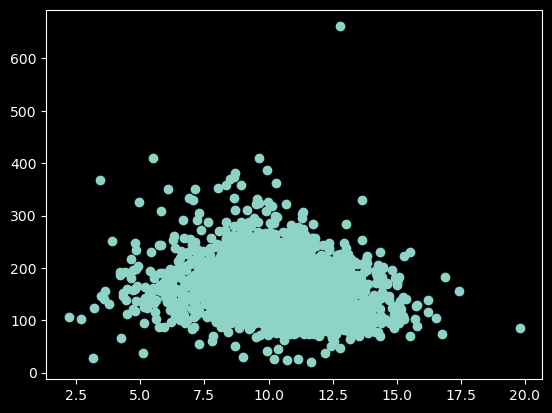

In [441]:
plt.scatter(heights, areas)

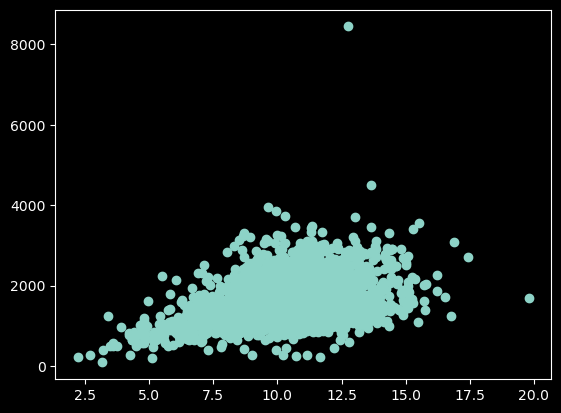

In [442]:
plt.scatter(heights, volumes)

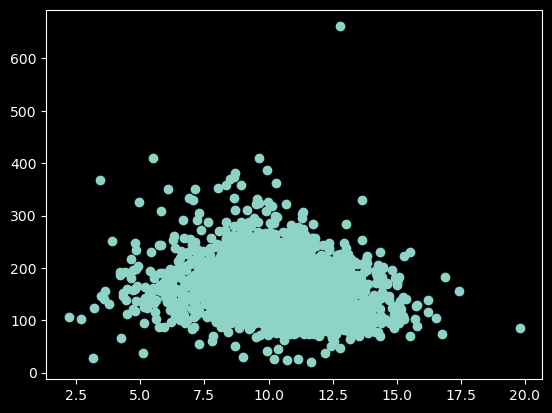

In [443]:
plt.scatter(heights, areas)

(array([0.000e+00, 2.000e+00, 8.000e+00, 3.700e+01, 7.700e+01, 2.190e+02,
        8.100e+02, 1.894e+03, 1.668e+03, 5.180e+02, 9.800e+01, 2.400e+01,
        4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400.,
        3600., 3800., 4000., 4200., 4400., 4600., 4800., 5000., 5200.,
        5400., 5600., 5800., 6000.]),
 [<matplotlib.patches.Polygon at 0x21de3590c90>])

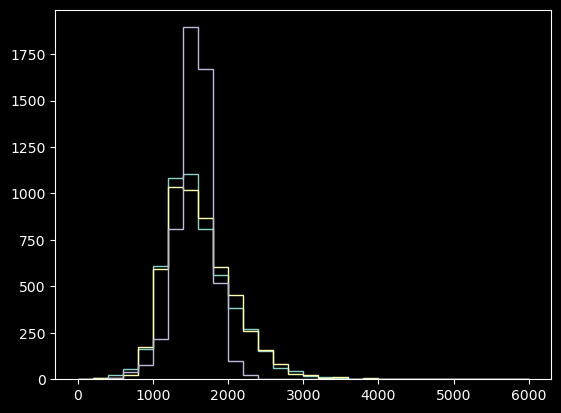

In [440]:
plt.hist(volumes, bins=30, range=(0,6000), histtype='step')
plt.hist(areas*np.nanmedian(heights), bins=30, range=(0,6000), histtype='step')
plt.hist(heights*np.nanmedian(areas), bins=30, range=(0,6000), histtype='step')

(-30.943875000000006,
 649.8213750000001,
 -43.4488125,
 912.4250625000001,
 1.0487163939292152,
 20.961200714111328)

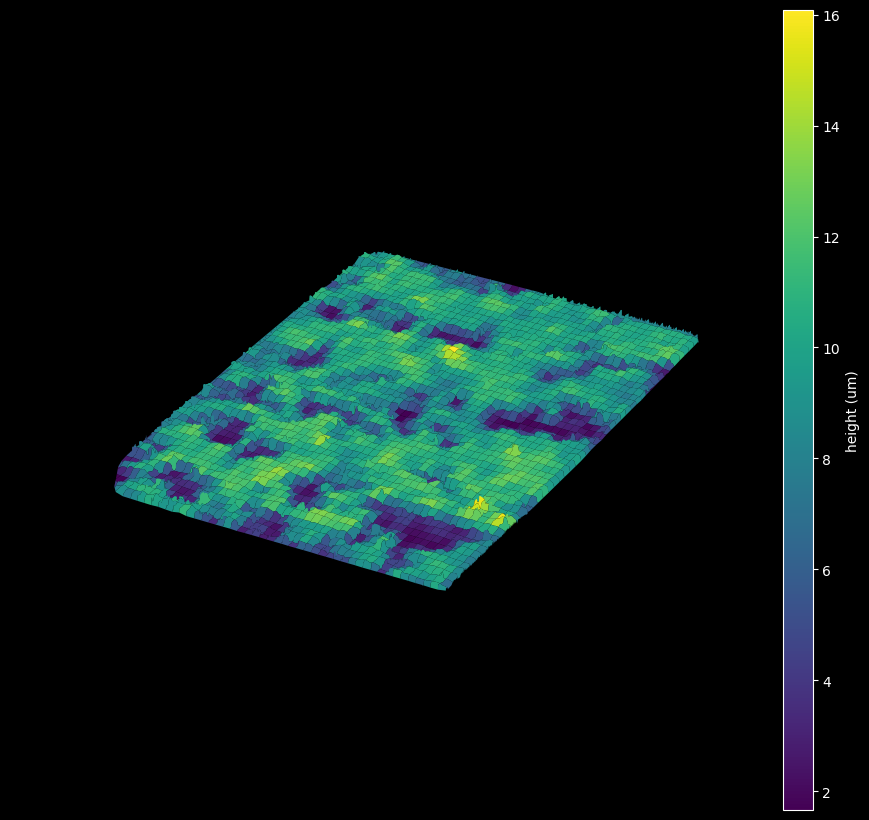

In [375]:
fig, ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': '3d'})
cb=ax.plot_surface(frame.x, frame.y, frame.z, cmap='viridis')

cax=fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(cb, cax=cax, label='height (um)')

ax.set_aspect('equal')
ax.axis('off')
#plt.savefig('plots/adhered_volumes/20240520_tile1_height_map.jpg', dpi=300, bbox_inches='tight')

# NORI

In [220]:
# Heather NORI - ImageJ binarization
seg_dir=r"Y:\Heather\20240720\segmented"
tiles_500k=[HeightMap(seg_path, scale=0.4143204, z_scale=1, load_img=True, NORI=True) for seg_path in tqdm(natsorted(glob(seg_dir+'/500k/*.npy')))]
tiles_50k=[HeightMap(seg_path, scale=0.4143204, z_scale=1, load_img=True, NORI=True) for seg_path in tqdm(natsorted(glob(seg_dir+'/50k/*.npy')))]
tiles_100k=[HeightMap(seg_path, scale=0.4143204, z_scale=1, load_img=True, NORI=True) for seg_path in tqdm(natsorted(glob(seg_dir+'/100k/*.npy')))]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [221]:
for tile in tqdm(tiles_50k+tiles_500k+tiles_100k):
    tile.get_volumes()

  0%|          | 0/45 [00:00<?, ?it/s]

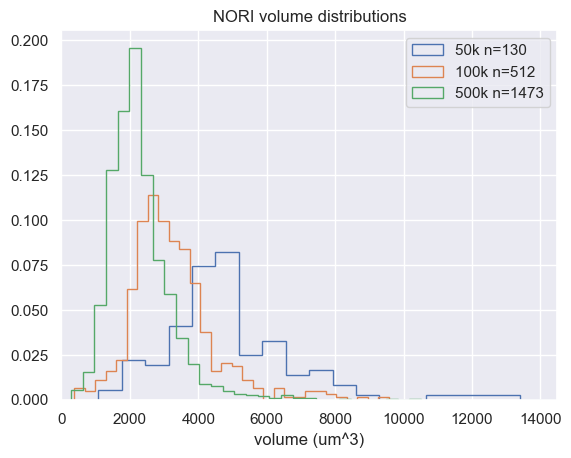

In [223]:
for dataset, label in zip([tiles_50k, tiles_100k, tiles_500k], ['50k', '100k', '500k']):
    volumes=np.concatenate([tile.volumes for tile in dataset])
    plt.hist(volumes, bins=30, histtype='step', weights=np.ones_like(volumes)/len(volumes), label=f'{label} n={np.sum(np.isfinite(volumes))}')

plt.legend()
plt.xlim(0,14500)
plt.xlabel('volume (um^3)')
plt.title('NORI volume distributions')
plt.savefig('plots/NORI_20240720/volume_distributions.jpg', dpi=300, bbox_inches='tight')

In [225]:
densities_50k=[]
masses_50k=[]
for tile in tqdm(tiles_50k):
    densities_50k.append(tile.get_NORI_density())
    masses_50k.append(tile.get_NORI_mass())

densities_50k=np.concatenate(densities_50k, axis=1)
masses_50k=np.concatenate(masses_50k, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\scipy\ndimage\_measurements.py:803: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\scipy\ndimage\_measurements.py:856: RuntimeWarning: invalid value encountered in divide
  return sum_c_sq / np.asanyarray(count).astype(float)


In [171]:
densities_100k=[]
masses_100k=[]
for tile in tqdm(tiles_100k):
    densities_100k.append(tile.get_NORI_density())
    masses_100k.append(tile.get_NORI_mass())

densities_100k=np.concatenate(densities_100k, axis=1)
masses_100k=np.concatenate(masses_100k, axis=1)

  0%|          | 0/14 [00:00<?, ?it/s]

In [226]:
densities_500k=[]
masses_500k=[]
for tile in tqdm(tiles_500k):
    densities_500k.append(tile.get_NORI_density())
    masses_500k.append(tile.get_NORI_mass())

densities_500k=np.concatenate(densities_500k, axis=1)
masses_500k=np.concatenate(masses_500k, axis=1)

  0%|          | 0/11 [00:00<?, ?it/s]

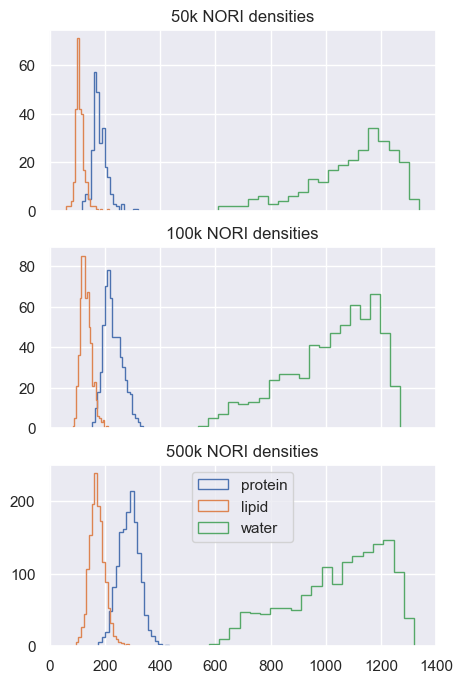

In [227]:
fig, axes=plt.subplots(3,1, figsize=(5,8), sharex=True)

for ax, densities, label in zip(axes, [densities_50k, densities_100k, densities_500k], ['50k', '100k', '500k']):
    ax.set_title(f'{label} NORI densities')
    ax.hist(densities[0], bins=20, histtype='step', label='protein')
    ax.hist(densities[1], bins=20, histtype='step', label='lipid')
    ax.hist(densities[2], bins=20, histtype='step', label='water')

plt.legend()

In [52]:
import seaborn as sns
sns.set_theme()

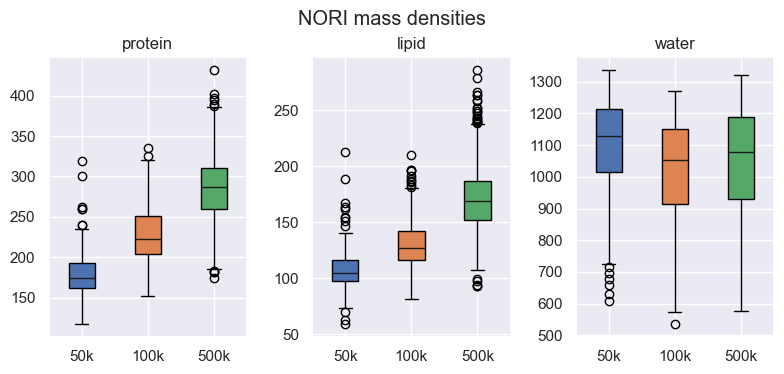

In [181]:
boxplot_data=[[densities[i] for densities in [densities_50k, densities_100k, densities_500k]] for i in range(3)]
fig, axes=plt.subplots(1,3, figsize=(8,4))

for ax, data, label in zip(axes, boxplot_data, ['protein', 'lipid', 'water']):
    ax.set_title(label)
    data=[densities[~np.isnan(densities)] for densities in data]
    boxes=ax.boxplot(data, labels=['50k', '100k', '500k'], widths=0.4, patch_artist=True)
    for patch, color in zip(boxes['boxes'], ['C0', 'C1', 'C2']):
        patch.set_facecolor(color)
    for median in boxes['medians']:
        median.set_color('k')

fig.suptitle('NORI mass densities', y=0.93)
fig.tight_layout()
plt.savefig('plots/NORI_20240720/mass_densities.jpg', dpi=300, bbox_inches='tight')

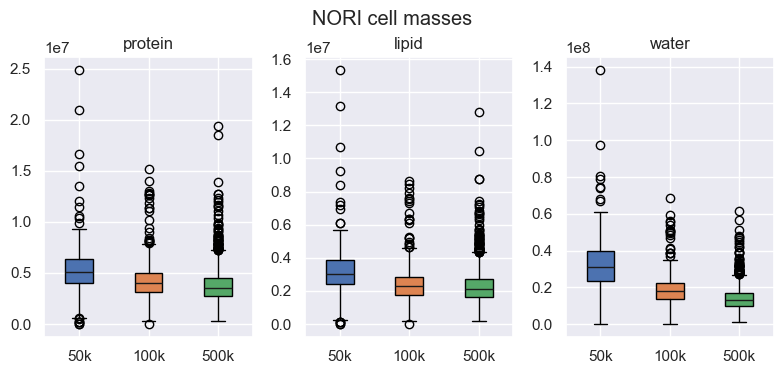

In [179]:
boxplot_data=[[densities[i] for densities in [masses_50k, masses_100k, masses_500k]] for i in range(3)]
fig, axes=plt.subplots(1,3, figsize=(8,4))

for ax, data, label in zip(axes, boxplot_data, ['protein', 'lipid', 'water']):
    ax.set_title(label)
    data=[densities[~np.isnan(densities)] for densities in data]
    boxes=ax.boxplot(data, labels=['50k', '100k', '500k'], widths=0.4, patch_artist=True)
    for patch, color in zip(boxes['boxes'], ['C0', 'C1', 'C2']):
        patch.set_facecolor(color)

    for median in boxes['medians']:
        median.set_color('k')

fig.suptitle('NORI cell masses', y=0.93)
fig.tight_layout()

plt.savefig('plots/NORI_20240720/total_mass.jpg', dpi=300, bbox_inches='tight')

In [228]:
volumes_50k=np.concatenate([tile.volumes for tile in tiles_50k])
volumes_500k=np.concatenate([tile.volumes for tile in tiles_500k])
volumes_100k=np.concatenate([tile.volumes for tile in tiles_100k])

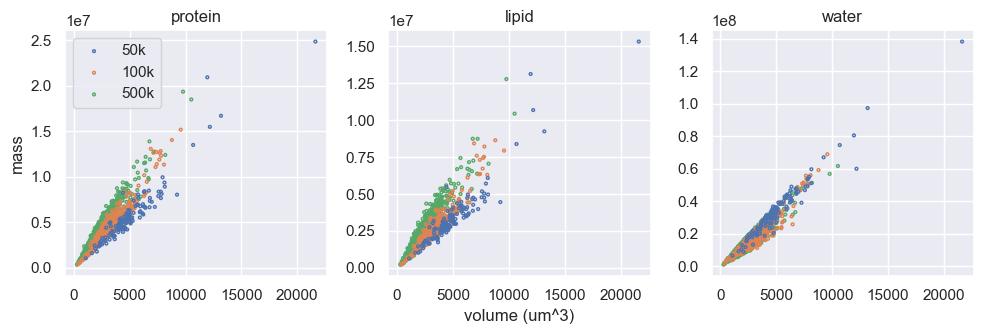

In [229]:
fig, axes=plt.subplots(1,3, figsize=(10,3.5))

for mass_50k, mass_100k, mass_500k, label, ax in zip(masses_50k, masses_100k, masses_500k, ['protein', 'lipid', 'water'], axes):
    ax.scatter(volumes_50k, mass_50k, label='50k', ec='C0', fc='none', s=4, zorder=5)
    ax.scatter(volumes_100k, mass_100k, label='100k', ec='C1', fc='none', s=4, zorder=4)
    ax.scatter(volumes_500k, mass_500k, label='500k', ec='C2', fc='none', s=4, zorder=3)
    ax.set_title(label)

axes[0].legend()
axes[1].set_xlabel('volume (um^3)')
axes[0].set_ylabel('mass')

fig.tight_layout()
plt.savefig('plots/NORI_20240720/mass_vs_volume.jpg', dpi=300, bbox_inches='tight')

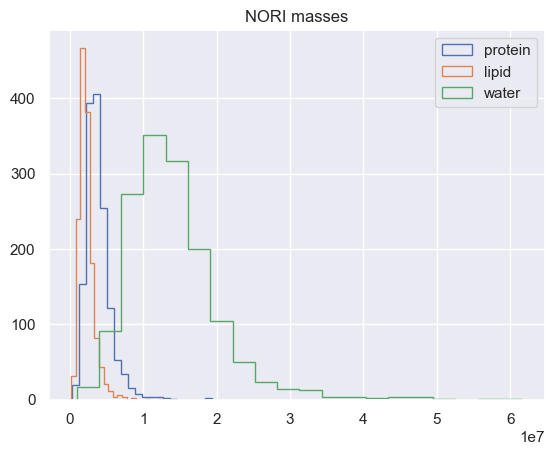

In [231]:
plt.title('NORI masses')
masses=masses_500k

plt.hist(masses[0], bins=20, histtype='step', label='protein')
plt.hist(masses[1], bins=20, histtype='step', label='lipid')
plt.hist(masses[2], bins=20, histtype='step', label='water')

plt.legend()

Text(0, 0.5, 'density')

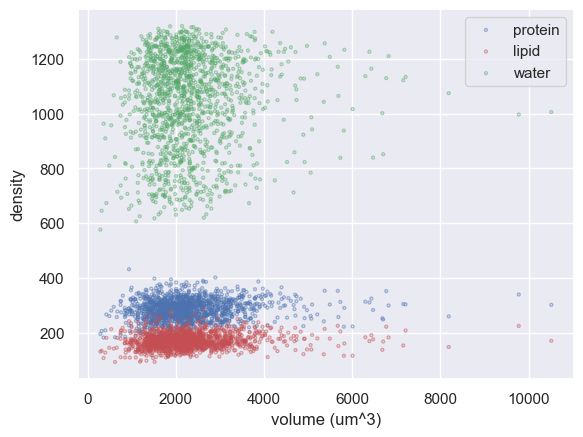

In [235]:
volumes=volumes_500k
densities=densities_500k

plt.scatter(volumes, densities[0], label='protein', fc='none', ec='b', s=4, alpha=0.5)
plt.scatter(volumes, densities[1], label='lipid', fc='none', ec='r', s=4, alpha=0.5)
plt.scatter(volumes, densities[2], label='water', fc='none', ec='g', s=4, alpha=0.5)

plt.legend()

plt.xlabel('volume (um^3)')
plt.ylabel('density')

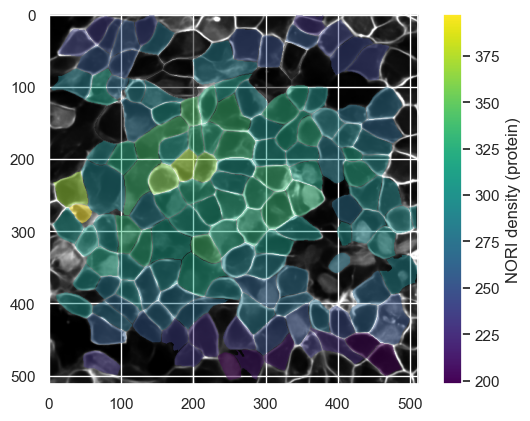

In [247]:
from monolayer_tracking import preprocessing
channel=0
n=4
tile=tiles_500k[n]

cmap_range=[np.nanmin(tile.NORI_density[channel]), np.nanmax(tile.NORI_density[channel])]
plt.imshow(preprocessing.normalize(tile.img[...,2]), cmap='gray')
for cell in tile.cells:
    color=plt.cm.viridis((cell.NORI_density[channel]-cmap_range[0])/(cmap_range[1]-cmap_range[0]))
    plt.fill(*cell.outline.T, fc=color, ec='none', linewidth=1, alpha=0.5)
    
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(*cmap_range)), ax=plt.gca(), label='NORI density (protein)')

# FUCCI measurement

In [56]:
from monolayer_tracking import preprocessing

for tile in tqdm(tiles):
    #tile.get_volumes()
    tile.FUCCI=np.array([tile.img[...,0], tile.img[...,1]])
    #tile.FUCCI[0]=ndimage.gaussian_filter(tile.FUCCI[0], sigma=5)
    #tile.FUCCI[1]=ndimage.gaussian_filter(tile.FUCCI[1], sigma=5)

    tile.FUCCI=preprocessing.normalize(tile.FUCCI, quantile=(0.01, 1))
    tile.measure_FUCCI(green_fluor_threshold=0.02, red_fluor_threshold=0.04, orange_brightness=2)

  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Andy\anaconda3\envs\cellpose\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


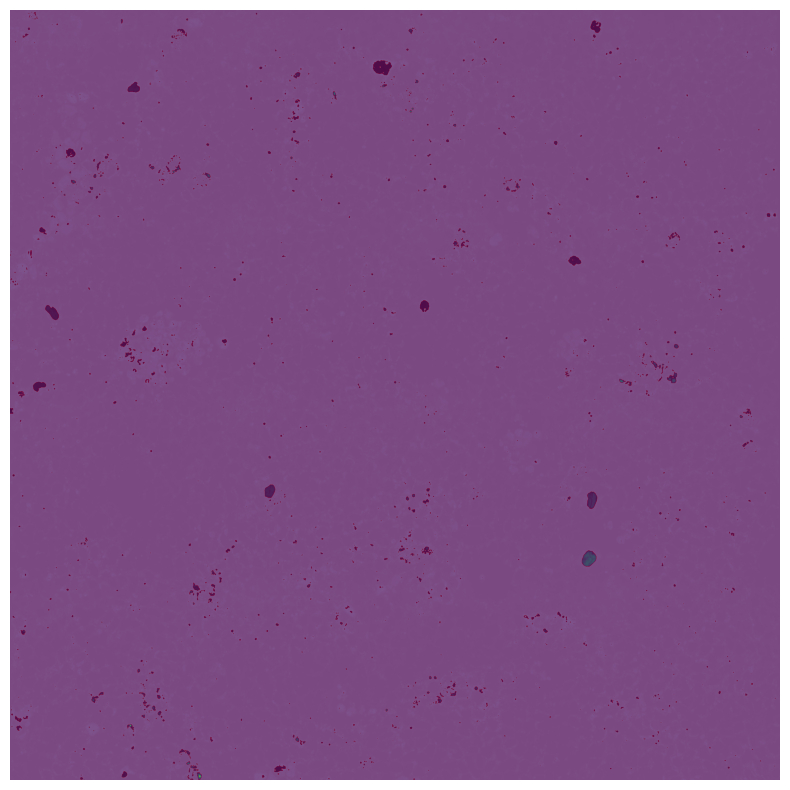

In [41]:
plt.figure(figsize=(10,10))
tile=tiles[0]
plt.imshow(tile.FUCCI[0])
plt.axis('off')
plt.imshow(tile.FUCCI[0]>0.04, cmap='Reds', alpha=0.3)

In [57]:
from monolayer_tracking.plot_tools import FUCCI_overlay

Text(0.5, 1.0, '20240715 tile1 FUCCI')

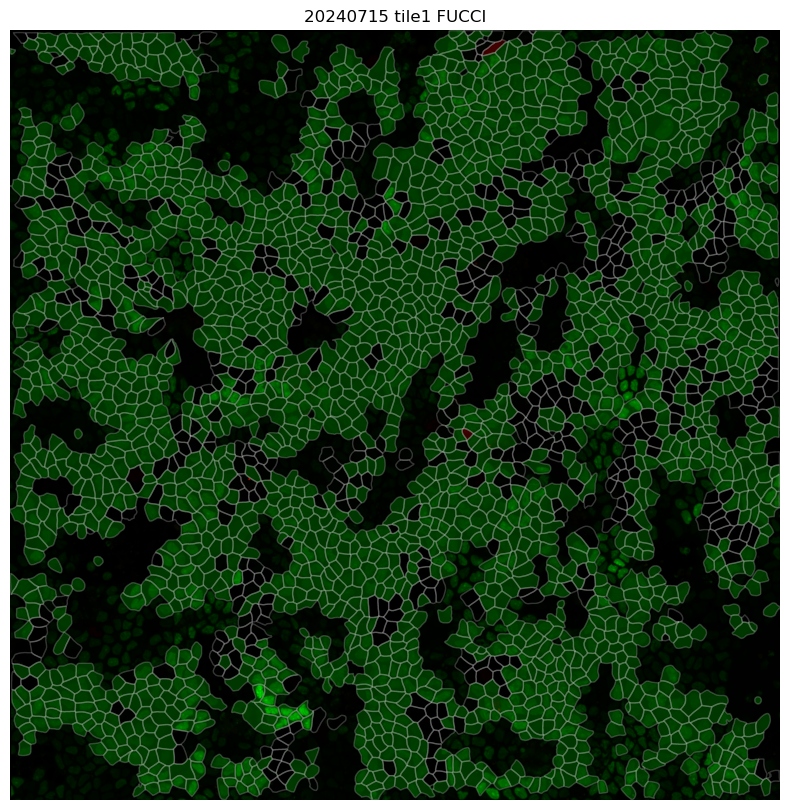

In [59]:
figsize=10
tile=tiles[1]
plt.figure(figsize=(figsize,figsize*np.divide(*tile.masks.shape)))
FUCCI_overlay(tile, show_denoised=True)

plt.title('20240715 tile1 FUCCI')
#plt.savefig('plots/adhered_volumes/20240520_tile1_FUCCI.jpg', dpi=300, bbox_inches='tight')

In [60]:
volumes=np.concatenate([tile.volumes for tile in tiles])
cell_cycles=np.concatenate([tile.get_cell_attr('cycle_stage') for tile in tiles])

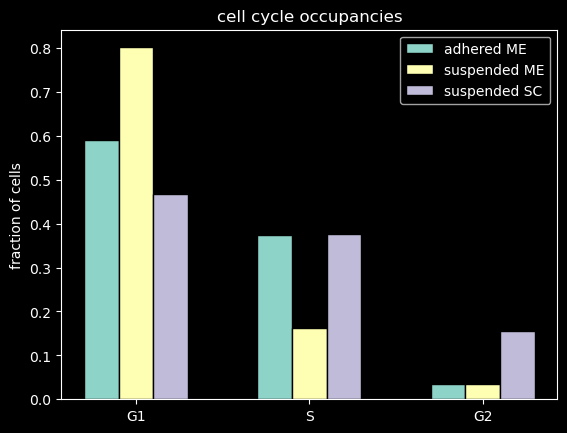

In [422]:
# bar chart of cell cycle occupancies
adhered_occupancies=np.unique(cell_cycles, return_counts=True)[1][1:]
suspended_ME_occupancies=np.array([len(v) for v in vol_0412_ME[1:]])
suspended_SC_occupancies=np.array([len(v) for v in vol_0407_SC[1:]])

adhered_occupancies=adhered_occupancies/np.sum(adhered_occupancies)
suspended_ME_occupancies=suspended_ME_occupancies/np.sum(suspended_ME_occupancies)
suspended_SC_occupancies=suspended_SC_occupancies/np.sum(suspended_SC_occupancies)

plt.bar(np.arange(3)-0.2, adhered_occupancies, width=0.2, label='adhered ME', edgecolor='k', color='C0')
plt.bar(np.arange(3), suspended_ME_occupancies, width=0.2, label='suspended ME', edgecolor='k', color='C1')
plt.bar(np.arange(3)+0.2, suspended_SC_occupancies, width=0.2, label='suspended SC', edgecolor='k', color='C2')

plt.xticks([0,1,2], ['G1', 'S', 'G2'])
plt.ylabel('fraction of cells')

plt.title('cell cycle occupancies')
plt.legend()

#plt.savefig('plots/adhered_volumes/20240520_tile1_cycle_occupancies.jpg', dpi=300, bbox_inches='tight')

(array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.0015, 0.0015, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.0015, 0.    , 0.    , 0.    , 0.003 , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ]),
 array([   0.        ,  133.33333333,  266.66666667,  400.        ,
         533.33333333,  666.66666667,  800.        ,  933.33333333,
        1066.66666667, 1200.        , 1333.33333333, 1466.66666667,
        1600.        , 1733.33333333, 1866.66666667, 2000.        ,
        2133.33333333, 2266.66666667, 2400.        , 2533.33333333,
        2666.66666667, 2800.        , 2933.33333333, 3066.66666667,
        3200.        , 3333.33333333, 3466.66666667, 3600.        ,
        3733.33333333, 3866.66666667, 4000.        , 4133.33333333,
        4266.66666667, 4400.        , 4533.333

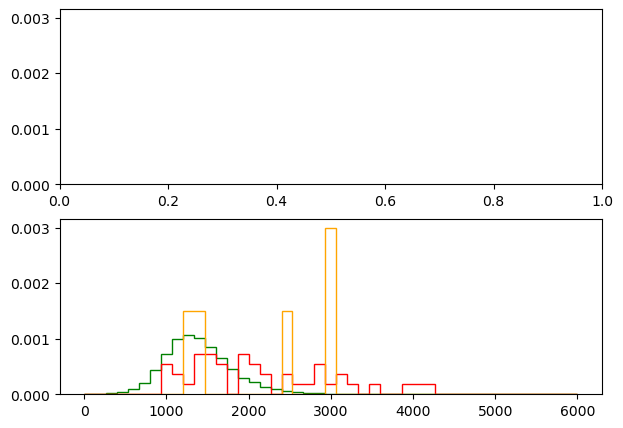

In [61]:
fig, axes=plt.subplots(2,1, figsize=(7,5), sharey=True)

axes[1].hist(volumes[cell_cycles==1], range=(0,6000), bins=45, histtype='step', color='green', density=True)
axes[1].hist(volumes[cell_cycles==2], range=(0,6000), bins=45, histtype='step', color='r', density=True)
axes[1].hist(volumes[cell_cycles==3], range=(0,6000), bins=45, histtype='step', color='orange', density=True)

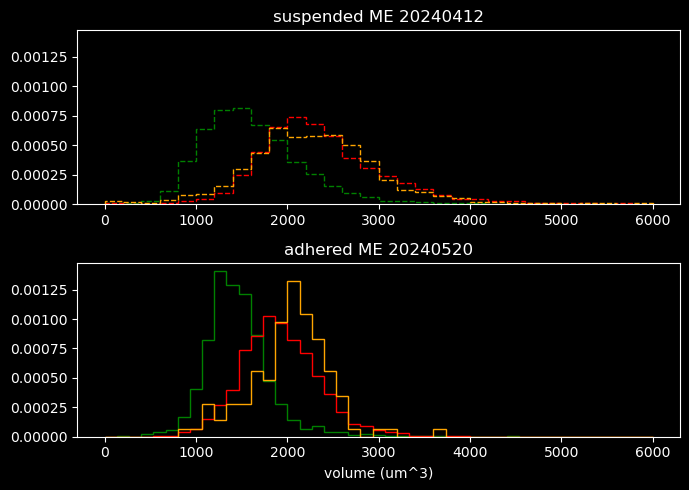

In [444]:
fig, axes=plt.subplots(2,1, figsize=(7,5), sharey=True)
axes[0].hist(vol_0412_ME[1], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='green')
axes[0].hist(vol_0412_ME[2], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='r')
axes[0].hist(vol_0412_ME[3], bins=30, range=(0,6000), density=True, histtype='step', linestyle='--', color='orange')
axes[0].set_title('suspended ME 20240412')

axes[1].hist(volumes[cell_cycles==1], range=(0,6000), bins=45, histtype='step', color='green', density=True)
axes[1].hist(volumes[cell_cycles==2], range=(0,6000), bins=45, histtype='step', color='r', density=True)
axes[1].hist(volumes[cell_cycles==3], range=(0,6000), bins=45, histtype='step', color='orange', density=True)
axes[1].set_title('adhered ME 20240520')

plt.xlabel('volume (um^3)')
fig.tight_layout()

#plt.savefig('plots/adhered_volumes/20240520_tile1_cycle_volumes.jpg', dpi=300, bbox_inches='tight')

In [62]:
adhered_volumes=[volumes[cell_cycles==i] for i in range(4)]

In [63]:
pd.to_pickle(adhered_volumes, r'Y:\my_data\W1\20240715 FUCCI halo ME 6days adhered_suspended\volumes/adhered.pkl')

# Deprecated: Read mesh.txt out of MGX

In [ ]:
def read_mesh(file_path):
    with open(file_path, 'r') as w:
        num_rows=int(w.readline())
    mesh=pd.read_csv(file_path, skiprows=1, delimiter=' ', header=None, index_col=0, nrows=num_rows)
    mesh.index.name=None
    mesh.columns=['x','y','z','?']
    
    return mesh

In [ ]:
# get mesh limits
full_mesh=read_mesh(r'Z:\Andy\segmentation\20240520 FUCCI halo ME 40x\tile5\tile5_mesh.txt')

full_mesh[['x','y','z']].min()

x   -309.60000
y   -434.56900
z     -9.83625
dtype: float64

In [ ]:
class HeightMapMesh(Image):
    def __init__(self, seg_path, mesh_path=None, scale=0.16125, **kwargs):
        super().__init__(seg_path, scale=scale, **kwargs)
        if mesh_path is None:
            mesh_path=seg_path.replace('seg.npy', 'topsurface.txt')
        self.mesh=read_mesh(mesh_path)
        
    def get_heights(self):
        from scipy.interpolate import LinearNDInterpolator

        self.interp=LinearNDInterpolator(self.mesh[['x','y']], self.mesh['z'])
        x_values=np.arange(self.masks.shape[1])*self.scale
        y_values=np.flip(np.arange(self.masks.shape[0])*self.scale)
        self.x, self.y=np.meshgrid(x_values, y_values)
        self.z=self.interp(self.x, self.y)
        
        return self.z
    
    def get_volumes(self):
        self.heights=self.get_heights()
        self.volumes=ndimage.sum(self.z, labels=self.masks, index=range(1,self.masks.max()+1))*self.scale**2
        self.mean_heights=ndimage.mean(self.z, labels=self.masks, index=range(1,self.masks.max()+1))
        self.set_cell_attr('volume', self.volumes)
        self.set_cell_attr('height', self.mean_heights)

        return self.volumes